<a href="https://colab.research.google.com/github/Listin4ever/Audio-Sentiment-Analysis/blob/main/audio_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Sentiment Analysis

The aim of this challenge is to read the audio (.wav) files and classify them into 3 sentiments (Positive, Neutral, or Negative).

Sentiments:-
- Positive
- Negative
- Neutral

We will be applying following Ensemble Algorithms:-

- NN with Tensorflow

# Reading & Understanding Data
## Importing Libraries

In [2]:
pip install librosa==0.9.2

In [3]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random, os
import librosa, IPython
import librosa.display as lplt
from skimage.io import imread
seed = 12
np.random.seed(seed)

### Loading Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
trainPath = '/content/drive/MyDrive/Data/Data for audio sentiment/TRAIN'
testPath = '/content/drive/MyDrive/Data/Data for audio sentiment/TEST'
df_base = pd.read_csv('/content/drive/MyDrive/Data/Data for audio sentiment/TRAIN.csv')
df_base.head()

,Filename,Class
0,346.wav,Negative
1,163.wav,Neutral
2,288.wav,Negative
3,279.wav,Negative
4,244.wav,Negative


### About the dataset

In [6]:
print("Dataset has",df_base.shape[0],"samples")
print("Count of Positive and Negative samples")
df_base['Class'].value_counts().reset_index()

Dataset has 250 samples
Count of Positive and Negative samples


,index,Class
0,Negative,87
1,Positive,82
2,Neutral,81


In [7]:
sample_rate = 44100
def loadAudio(fp):
    return librosa.load(fp, res_type='kaiser_fast', duration=2.5, offset=0.5, sr=sample_rate)

### MelSpec -> Array

In [8]:
def scanFeatures(path, avgFeat=0):
    features = []
    minFeat = sys.maxsize
    maxFeat = 0
    files = sorted(os.listdir(path))
    print("Scanning", path)

    for i, fp in enumerate(files):
        X, sr = loadAudio(os.path.join(path, fp))

        f = librosa.feature.melspectrogram(y=X, sr=sample_rate)
        f = librosa.amplitude_to_db(f, ref=np.max)

        shapeY = f.shape[1]
        if shapeY < minFeat:
            minFeat = shapeY

        if shapeY > maxFeat:
            maxFeat = shapeY

        features.append(f)
    if avgFeat == 0:
        avgFeat = int((minFeat+maxFeat)/2)
    feat_mat = np.zeros((len(files), f.shape[0], avgFeat))
    for i, x in enumerate(features):
        xWidth = min(x.shape[1],avgFeat)
        feat_mat[i, :, :xWidth] = x[:,:xWidth]
    return feat_mat, files

In [9]:
f_dim = 128
train_data, train_files = scanFeatures(trainPath, f_dim)
test_data, test_files = scanFeatures(testPath, train_data.shape[1])
print(train_data.shape)
print(test_data.shape)

Scanning /content/drive/MyDrive/Data/Data for audio sentiment/TRAIN
Scanning /content/drive/MyDrive/Data/Data for audio sentiment/TEST
(250, 128, 128)
(131, 128, 128)


### MelSpec -> Images

In [10]:
def saveImg(f, fp):
    f = np.flip(f, axis=0)
    plt.figure()
    plt.axis('off')
    plt.imsave(fp, f, format='png')
    plt.clf()

In [11]:
def saveFeatureToImage(path, saveDir, avgFeat=0):
    global sample_rate
    files = sorted(os.listdir(path))
    print("Scanning", path)

    for i, fp in enumerate(files):
        X, sr = loadAudio(os.path.join(path, fp))

        f = librosa.feature.melspectrogram(y=X, sr=sample_rate)
        f = librosa.amplitude_to_db(f, ref=np.max)

        img = np.zeros((f.shape[0], avgFeat))
        xWidth = min(f.shape[1],avgFeat)
        img[:, :xWidth] = f[:,:xWidth]
        fname = os.path.join(saveDir, fp.split('.')[0] + '.png')
        saveImg(img, fname)

In [12]:
f_dim = 128
train_img_dir = '/content/drive/MyDrive/Data/Data for audio sentiment/train_images'
test_img_dir = '/content/drive/MyDrive/Data/Data for audio sentiment/test_images'
if not os.path.exists(train_img_dir):
    os.mkdir(train_img_dir)
    saveFeatureToImage(trainPath, train_img_dir, f_dim)
if not os.path.exists(test_img_dir):
    os.mkdir(test_img_dir)
    saveFeatureToImage(testPath, test_img_dir, train_data.shape[1])

In [13]:
def scanImgFeatures(path):
    features = []
    files = sorted(os.listdir(path))
    for x in files:
        fp = os.path.join(path, x)
        img = imread(fp)[:,:,:3]/255.0
        features.append(img)
    return np.array(features), files

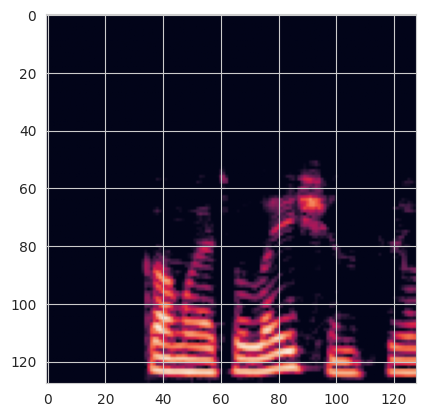

In [14]:
if os.path.exists(train_img_dir):
    train_data_img, train_files_img = scanImgFeatures(train_img_dir)
if os.path.exists(test_img_dir):
    test_data_img, test_files_img = scanImgFeatures(test_img_dir)
    plt.imshow(test_data_img[0])
    plt.show()

In [15]:
def getPathLabels(p):
    return [df_base[df_base['Filename'] == x].iloc[0,1] for x in p]

In [16]:
train_labels = getPathLabels(train_files)

# Data Visualization

In [17]:
audio_fp = '/content/drive/MyDrive/Data/Data for audio sentiment/TRAIN/1.wav'
audio_data, sr = loadAudio(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [18]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

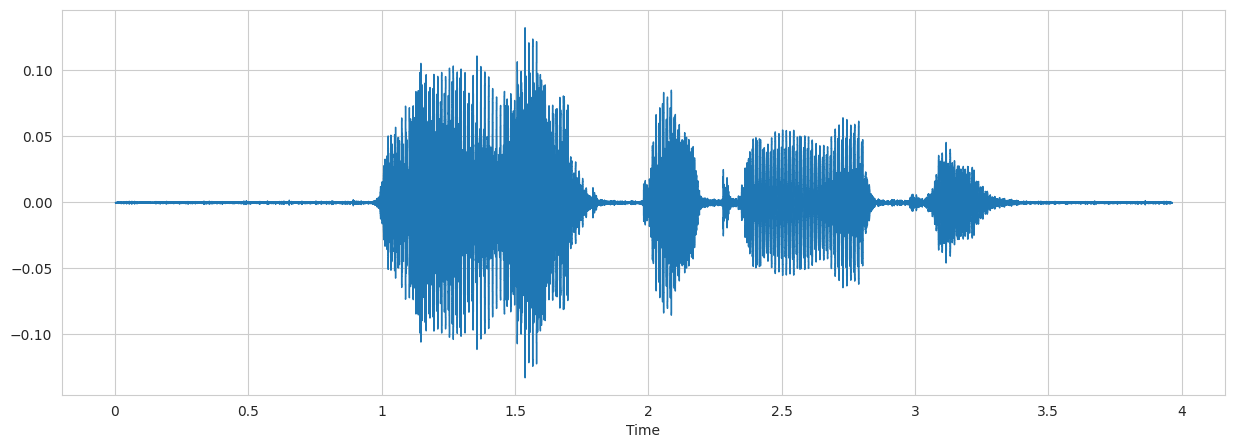

In [19]:
# plot sample file
plt.figure(figsize=(15,5))
lplt.waveshow(audio_data)
plt.show()

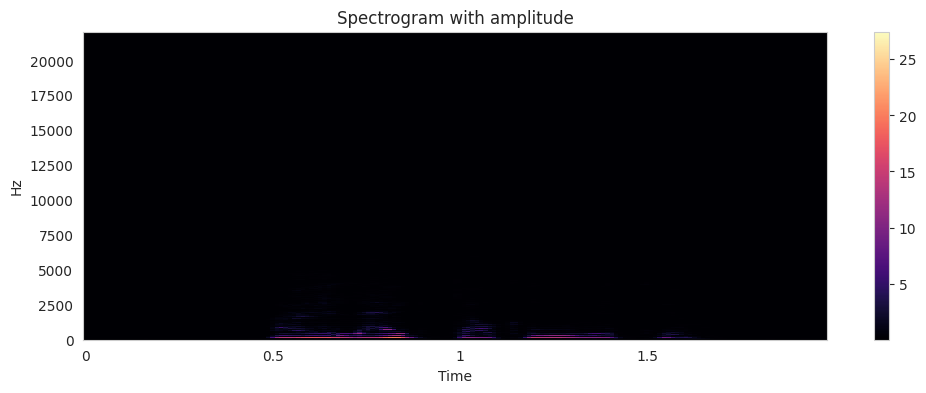

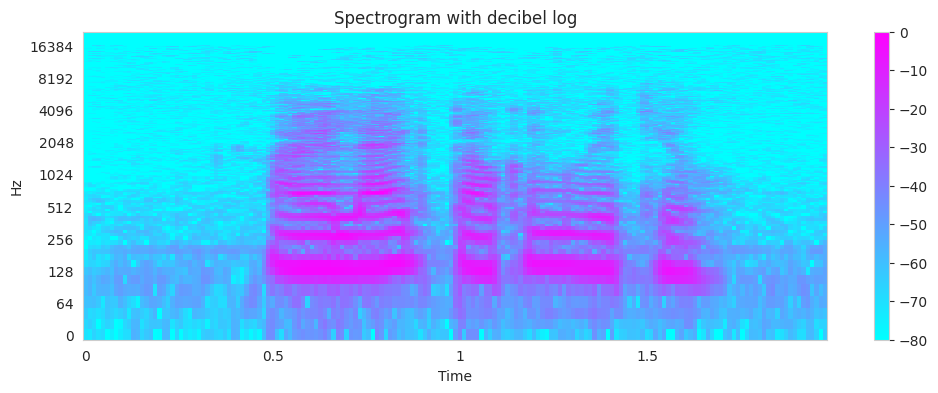

In [20]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

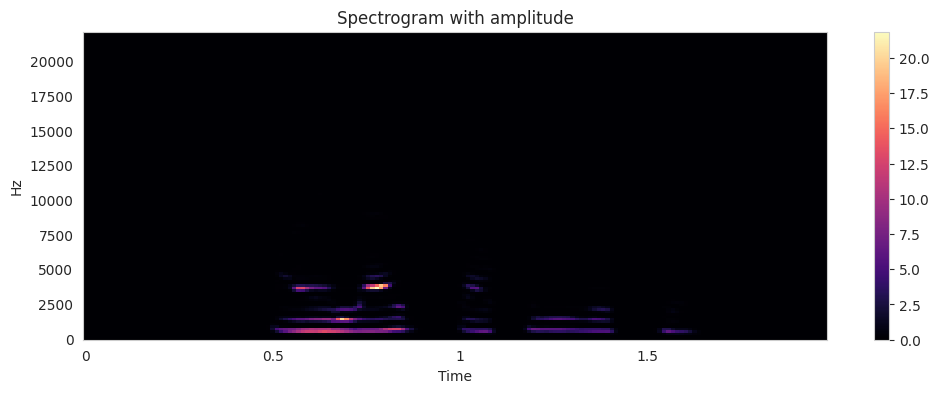

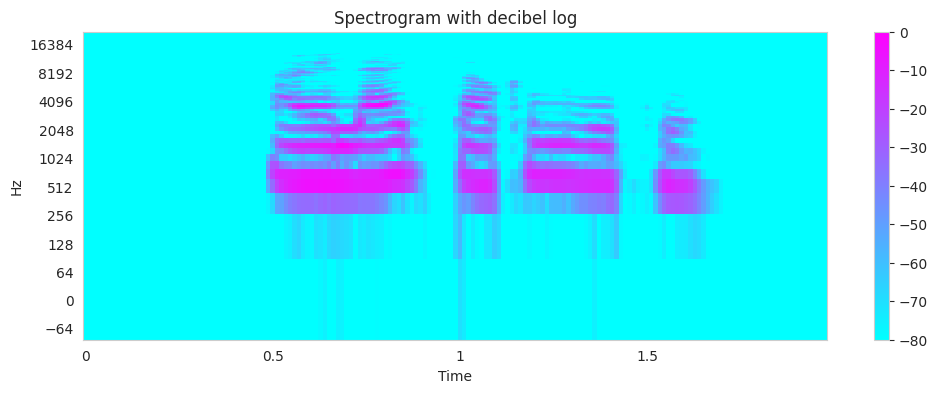

In [21]:
melspec = librosa.feature.melspectrogram(audio_data, sr=sample_rate)
melspec_db = librosa.amplitude_to_db(melspec, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(melspec, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(melspec_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

# Data Preparation


## Encode Genre Label

In [22]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df_base['Class'].unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'Negative': 0, 'Neutral': 1, 'Positive': 2}
{0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [23]:
# update labels in df to index
train_labels_idx = [label_index[l] for l in train_labels]
train_labels_idx[::10]

[2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2]

# Split Train & Test Sets

In [24]:
# shuffle samples
df_shuffle = df_base.sample(frac=1, random_state=seed).reset_index(drop=True)

In [25]:
# remove irrelevant columns
df_shuffle.drop(['Filename'], axis=1, inplace=True)
df_y = df_shuffle.pop('Class')

# split into train dev and test
y_train, y_test = skms.train_test_split(df_y, train_size=0.8, random_state=seed, stratify=df_y)

In [26]:
print(f"Train set has {y_train.shape[0]} records out of {len(df_shuffle)} which is {round(y_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {y_test.shape[0]} records out of {len(df_shuffle)} which is {round(y_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 200 records out of 250 which is 80%
Test set has 50 records out of 250 which is 20%


In [27]:
# stratified split check
print(y_train.value_counts())
print(y_test.value_counts())

Negative    69
Positive    66
Neutral     65
Name: Class, dtype: int64
Negative    18
Neutral     16
Positive    16
Name: Class, dtype: int64


In [28]:
# divide train_data into X_train and X_test
X_train = train_data[y_train.index.tolist(), :, :]
X_test = train_data[y_test.index.tolist(), :, :]
X_test.shape

(50, 128, 128)

In [29]:
# divide train_data_img into X_train_img and X_test_img
X_train_img = train_data_img[y_train.index.tolist(), :, :]
X_test_img = train_data_img[y_test.index.tolist(), :, :]
X_test_img.shape

(50, 128, 128, 3)

In [30]:
y_train = np.array([train_labels_idx[x] for x in y_train.index.tolist()])
y_test = np.array([train_labels_idx[x] for x in y_test.index.tolist()])
y_train[::10]

array([1, 2, 2, 2, 2, 0, 2, 0, 1, 1, 1, 1, 2, 0, 0, 2, 1, 0, 0, 2])

## Scale the Features

In [31]:
# scale features
scaler = skp.MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
test_data = scaler.transform(test_data.reshape(-1, test_data.shape[-1])).reshape(test_data.shape)
print(X_train.shape)

(200, 128, 128)


# Model Building

In [32]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
from keras import backend as K
tf.random.set_seed(seed)

TF version:- 2.14.0


In [33]:
bestModelPath = './best_model.hdf5'
ACCURACY_THRESHOLD = 0.98

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

acc_callback = myCallback()


def trainModel(model, epochs, optimizer, vb=1):
    cbs = [#k.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
           k.callbacks.ModelCheckpoint(filepath=bestModelPath, monitor='val_loss', verbose=1, save_best_only=True)]
    batch_size = 64
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train,
#                      validation_data=(X_test, y_test),
                     epochs=epochs, verbose=vb,
                     validation_split=0.2,
                     batch_size=batch_size, callbacks=cbs)

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [34]:
model_1 = k.models.Sequential([
    k.layers.Conv1D(256, 8, padding='same', activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
#     k.layers.Conv1D(256, 8, padding='same', activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.Dropout(0.2),
    k.layers.MaxPooling1D(pool_size=(8)),
    k.layers.Conv1D(128, 8, padding='same', activation='relu'),
#     k.layers.Conv1D(128, 8, padding='same', activation='relu'),
#     k.layers.Conv1D(128, 8, padding='same', activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.Dropout(0.2),
    k.layers.MaxPooling1D(pool_size=(5)),
#     k.layers.Conv1D(64, 8, padding='same', activation='relu'),
    k.layers.Conv1D(64, 8, padding='same', activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.Flatten(),
#     k.layers.Dense(64, activation='relu'),
    k.layers.Dense(len(index_label), activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=50, optimizer='adam', vb=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 256)          262400    
                                                                 
 batch_normalization (Batch  (None, 128, 256)          1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           262272    
                                                                 
 batch_normalization_1 (Bat  (None, 16, 128)           5

Max. Validation Accuracy 0.824999988079071


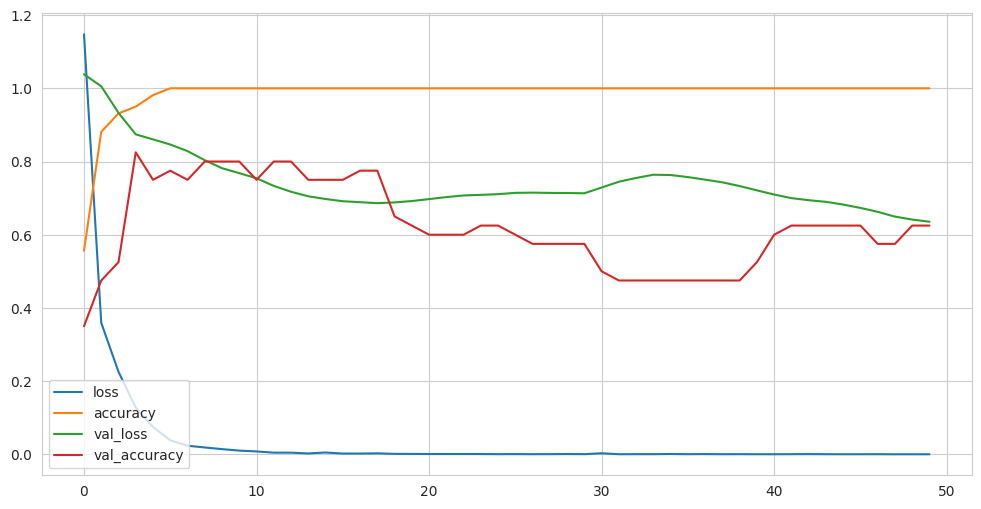

In [35]:
plotHistory(model_1_history)

In [36]:
# evaluation
test_loss, test_acc  = k.models.load_model(bestModelPath).evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("The test Accuracy is :",test_acc*100)

1/1 [==============================] - 0s 295ms/step - loss: 0.7581 - accuracy: 0.5800
The test Loss is : 0.7581372857093811
The test Accuracy is : 57.999998331069946


In [37]:
model_2 = k.models.Sequential([
    k.layers.Conv1D(256, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    k.layers.BatchNormalization(),
    k.layers.Dropout(0.3),
    k.layers.MaxPooling1D(pool_size=(2)),
    k.layers.Conv1D(128, 3, activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.Dropout(0.3),
    k.layers.MaxPooling1D(pool_size=(3)),
    k.layers.Conv1D(64, 3, activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.Flatten(),
    k.layers.Dense(32, activation='relu'),
    k.layers.Dense(len(index_label), activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=100, optimizer='adam', vb=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 124, 256)          164096    
                                                                 
 batch_normalization_3 (Bat  (None, 124, 256)          1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 124, 256)          0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 62, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 60, 128)           98432     
                                                                 
 batch_normalization_4 (Bat  (None, 60, 128)          

Max. Validation Accuracy 0.875


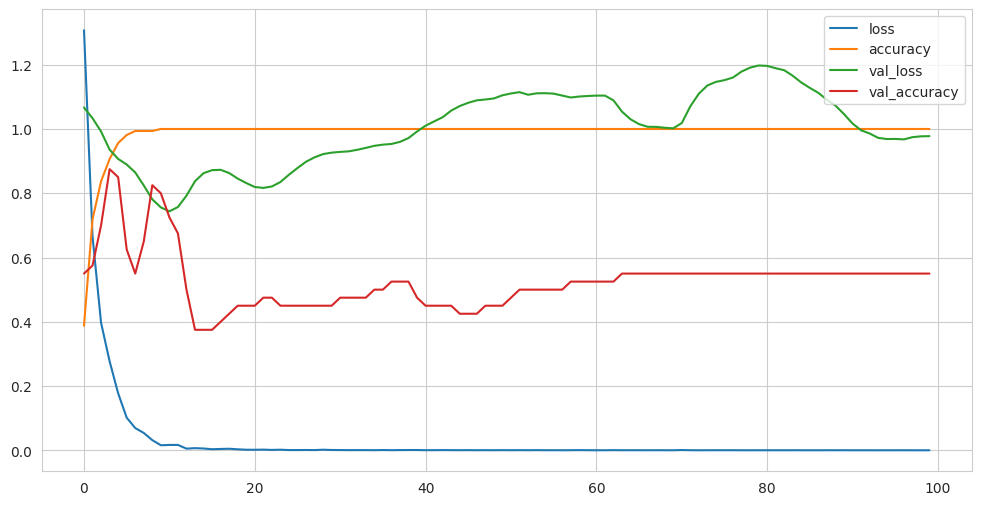

In [38]:
plotHistory(model_2_history)

In [39]:
# evaluation
test_loss, test_acc  = k.models.load_model(bestModelPath).evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("The test Accuracy is :",test_acc*100)

1/1 [==============================] - 0s 282ms/step - loss: 0.8368 - accuracy: 0.6400
The test Loss is : 0.8367940783500671
The test Accuracy is : 63.999998569488525


In [40]:
model_3 = k.models.Sequential([
    k.layers.Bidirectional(k.layers.LSTM(256, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),

    k.layers.Bidirectional(k.layers.LSTM(128, return_sequences=False)),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(32, activation='relu'),
    k.layers.Dense(len(index_label), activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=100, optimizer='rmsprop', vb=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128, 512)          788480    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

Max. Validation Accuracy 0.875


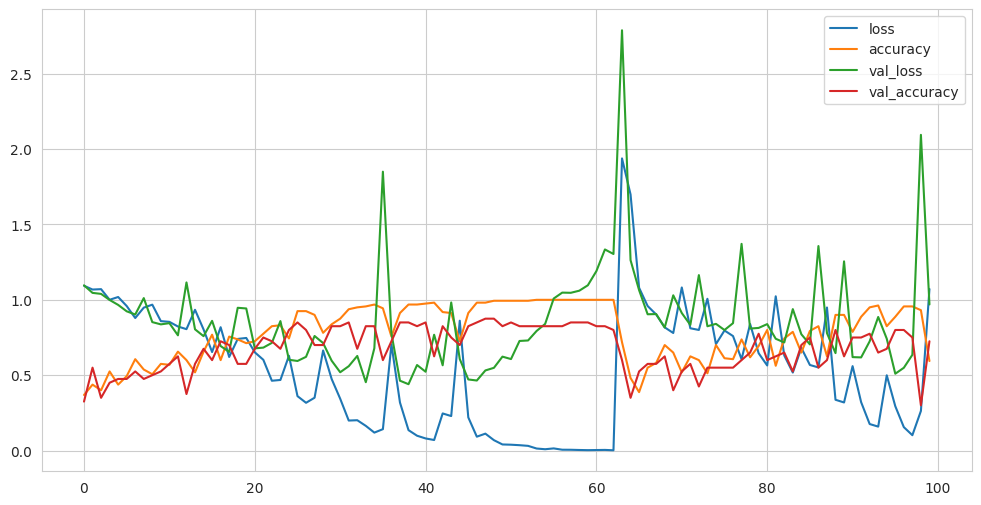

In [41]:
plotHistory(model_3_history)

In [42]:
# evaluation
test_loss, test_acc  = k.models.load_model(bestModelPath).evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("The test Accuracy is :",test_acc*100)

1/1 [==============================] - 2s 2s/step - loss: 0.3800 - accuracy: 0.8600
The test Loss is : 0.38002169132232666
The test Accuracy is : 86.00000143051147


In [43]:
# make features 3D with last dim as 1 for 1DConv
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_train.shape

(200, 128, 128, 1)

In [45]:
model_4 = k.models.Sequential([
    k.layers.Conv2D(256, (5,5), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    k.layers.BatchNormalization(),
    k.layers.MaxPooling2D(pool_size=(2)),
    k.layers.Dropout(0.3),
    k.layers.Conv2D(128, (3,3), activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.MaxPooling2D(pool_size=(2)),
    k.layers.Dropout(0.3),
    k.layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.Flatten(),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(len(index_label), activation='softmax'),

])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=50, optimizer='adam', vb=0)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 256)     6656      
                                                                 
 batch_normalization_9 (Bat  (None, 124, 124, 256)     1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 256)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 62, 62, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 128)       295040    
                                                                 
 batch_normalization_10 (Ba  (None, 60, 60, 128)      

Max. Validation Accuracy 0.2750000059604645


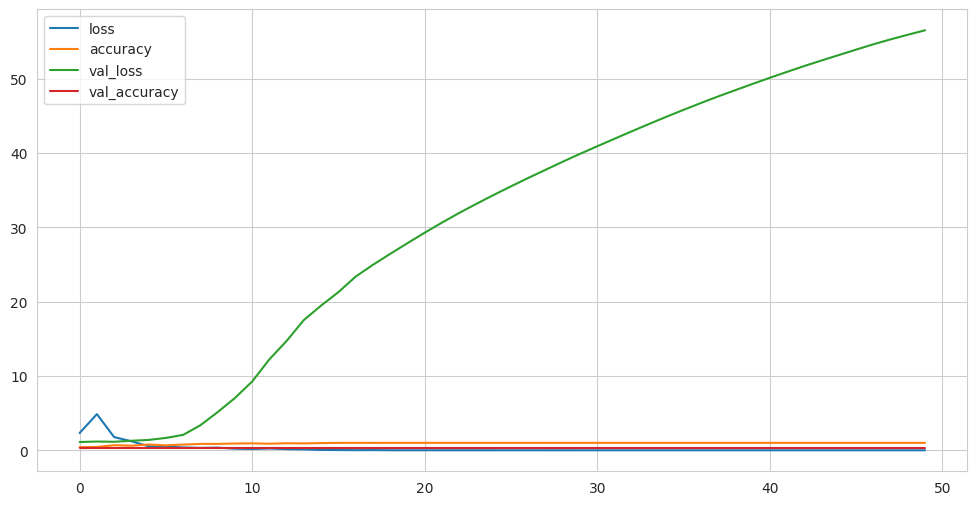

In [46]:
plotHistory(model_4_history)

In [47]:
# evaluation
test_loss, test_acc  = k.models.load_model(bestModelPath).evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("The test Accuracy is :",test_acc*100)

1/1 [==============================] - 5s 5s/step - loss: 1.0854 - accuracy: 0.3800
The test Loss is : 1.0853586196899414
The test Accuracy is : 37.99999952316284


In [48]:
inputShape = (X_train.shape[1], X_train.shape[2], 1)
model_5 = k.models.Sequential([
    k.layers.TimeDistributed(k.layers.Conv1D(256, 5), input_shape=inputShape),
    k.layers.TimeDistributed(k.layers.BatchNormalization()),
    k.layers.TimeDistributed(k.layers.MaxPooling1D((2))),
    k.layers.TimeDistributed(k.layers.Dropout(0.3)),

    k.layers.TimeDistributed(k.layers.Conv1D(128, 3), input_shape=inputShape),
    k.layers.TimeDistributed(k.layers.BatchNormalization()),
    k.layers.TimeDistributed(k.layers.MaxPooling1D((2))),
    k.layers.TimeDistributed(k.layers.Dropout(0.3)),
    k.layers.TimeDistributed(k.layers.Flatten())

], name="conv_3d7")

model_5.add(k.layers.Bidirectional(k.layers.LSTM(256, return_sequences=True)))
model_5.add(k.layers.Dropout(0.3))

model_5.add(k.layers.Bidirectional(k.layers.LSTM(128)))
model_5.add(k.layers.Dropout(0.3))

model_5.add(k.layers.Dense(64, activation='relu'))
model_5.add(k.layers.Dropout(0.3))

model_5.add(k.layers.Dense(len(index_label), activation='softmax'))

print(model_5.summary())
model_5_history = trainModel(model=model_5, epochs=100, optimizer='adam', vb=0)

Model: "conv_3d7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 128, 124, 256)     1536      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 128, 124, 256)     1024      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 128, 62, 256)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 128, 62, 256)      0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 128, 60, 128)      984

Max. Validation Accuracy 0.8500000238418579


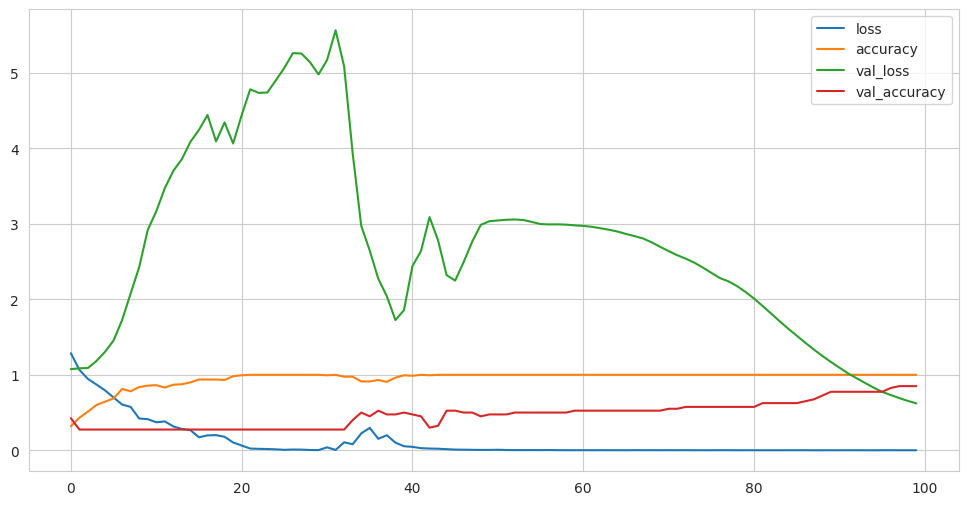

In [49]:
plotHistory(model_5_history)

In [50]:
# evaluation
test_loss, test_acc  = k.models.load_model(bestModelPath).evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("The test Accuracy is :",test_acc*100)

1/1 [==============================] - 17s 17s/step - loss: 1.3253 - accuracy: 0.8400
The test Loss is : 1.3252854347229004
The test Accuracy is : 83.99999737739563


## Model using Image Data

In [51]:
modelPath = './best_model.hdf5'
ACCURACY_THRESHOLD = 0.95

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

acc_callback = myCallback()

cbs = [#k.callbacks.ReduceLROnPlateau(patience=3, verbose=1),
       k.callbacks.ModelCheckpoint(filepath=modelPath, monitor='val_loss', verbose=1, save_best_only=True)]

def trainImgModel(model, epochs, optimizer, vb=1):
    batch_size = 64
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train_img, y_train,
                     validation_data=(X_test_img, y_test), epochs=epochs, verbose=vb,
                     batch_size=batch_size, callbacks=cbs)

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [52]:
model_6 = k.models.Sequential([
    k.layers.Conv2D(256, 3, activation='relu', input_shape=(128, 128, 3)),
    k.layers.BatchNormalization(),
    k.layers.MaxPooling2D(pool_size=(2)),
    k.layers.Dropout(0.2),
    k.layers.Conv2D(128, 3, activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.MaxPooling2D(pool_size=(2)),
    k.layers.Dropout(0.2),
    k.layers.Conv2D(64, 3, padding='same', activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.Flatten(),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(len(index_label), activation='softmax'),

])
print(model_6.summary())
model_6_history = trainImgModel(model=model_6, epochs=100, optimizer='rmsprop', vb=0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 batch_normalization_14 (Ba  (None, 126, 126, 256)     1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 256)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 63, 63, 256)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 128)       295040    
                                                                 
 batch_normalization_15 (Ba  (None, 61, 61, 128)      

Max. Validation Accuracy 0.46000000834465027


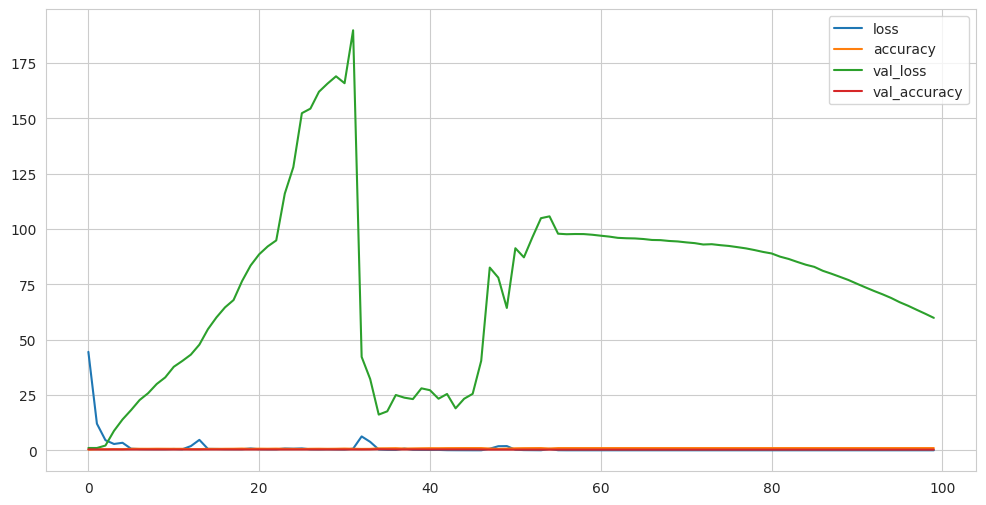

In [53]:
plotHistory(model_6_history)

In [54]:
# model evaluation
test_loss, test_acc  = k.models.load_model(bestModelPath).evaluate(X_test_img, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("The test Accuracy is :",test_acc*100)

1/1 [==============================] - 4s 4s/step - loss: 1.0312 - accuracy: 0.3600
The test Loss is : 1.0312232971191406
The test Accuracy is : 36.000001430511475


In [ ]:
# test_data = np.expand_dims(test_data, axis=3)

In [55]:
predictions = np.argmax(k.models.load_model(bestModelPath).predict(test_data_img), axis=1)
predictions

4/4 [==============================] - 10s 2s/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [56]:
df_sub = pd.DataFrame({
    'Filename': test_files,
    'Class': list(map(lambda x:index_label[x], predictions))
})
df_sub.head()

ValueError: ignored

In [57]:
submission_file = 'submission.csv'
df_sub.to_csv(submission_file, index=False)

NameError: ignored